# Comparison Pauli vs Randomized Clifford vs Randomized Rotation

* Author: Michel Meulen
* Date: 08-04-2025
* Contact: michel.meulen@tno.nl
-----------------------------------
This notebook contains comparison between the *Pauli-based* vs *Randomized-based with random Clifford circuits* vs *Randomized-based with random rotation gates* way of applying wire cuts (time-wise) on a quantum circuit. For both use cases a Greenberger Horne Zeilinger (GHZ) state quantum circuit is used. 

In [1]:
from original_circuit import Circuit
from GHZ_pauli_wire_cut import GHZPauliWireCut
from GHZ_random_measurements import GHZRandomWireCut
from circuit_configurations.circuit_random_gates_configuration import RandomCircuitGatesConfiguration
from circuit_configurations.circuit_random_rotations_configuration import RandomCircuitRotationsConfiguration
from circuit_configurations.circuit_configuration import CircuitConfiguration
from circuit_arguments.circuit_gate_argument import CircuitGateArgument
from circuit_gate import CircuitGate

from quantum_wire_cutting import QuantumWireCutUtils as qwc
from quantum_utils import QuantumUtils as qu
from quantum_channel import QuantumChannel

from benchmark import Benchmark, BenchmarkResult

Are you sure you want to overwrite previous results?
This means previous results cannot be recovered.
Shots interval: 1000 is done
Shots interval: 2000 is done
Shots interval: 3000 is done


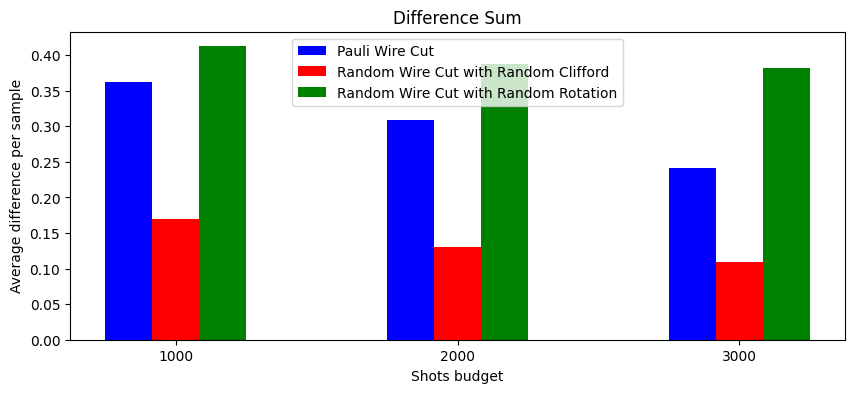

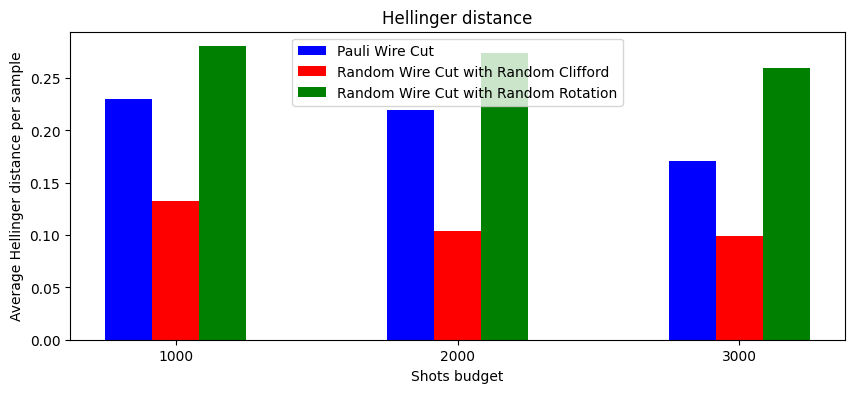

In [ ]:

# Parameters for the three wire cut techniques
SAMPLES: int = 1000
NUMBER_OF_QUBITS: int = 5
NUMBER_OF_CUTS: int = 2
USE_QUANTUM_TELEPORTATION: bool = True
OUTPUT_FILE_NAME: str = "BenchmarkResults"

# Initialize list to store the measured data in
results = [0, 0, 0]; hellingerDistance = [0, 0, 0]
shotsIntervals = [1000, 2000, 3000]

# Create benchmark object for storing the results in a CSV and Binary for later use.
benchmark = Benchmark()
benchmark.AddHeader("Description")
benchmark.AddHeader("Samples")
benchmark.AddHeader("Qubits")
benchmark.AddHeader("Cuts")
benchmark.AddHeader("Config")
benchmark.AddHeader("Shots")
benchmark.AddHeader("Difference Sum")
benchmark.AddHeader("Hellinger Distance")

for index, shotsInvertal in enumerate(shotsIntervals):
        
    for i in range(SAMPLES):
        # Configuration selection
        # Random quantum gates e.g. X, Y, Z, S between the GHZ circuit.
        # CONFIG = RandomCircuitGatesConfiguration(NUMBER_OF_QUBITS, NUMBER_OF_QUBITS)
        
        # Random rotation gates e.g. RX, RY, RZ between the GHZ circuit.
        CONFIG = RandomCircuitRotationsConfiguration(NUMBER_OF_QUBITS, NUMBER_OF_QUBITS)
        
        # Custom gates configuration with quantum gates: X, Y, Z, S
        # # CONFIG = CircuitConfiguration(NUMBER_OF_QUBITS, NUMBER_OF_QUBITS)
        # CONFIG = CircuitConfiguration([
        #     CircuitGateArgument(1, CircuitGate.X),
        #     CircuitGateArgument(2, CircuitGate.Y),
        #     CircuitGateArgument(3, CircuitGate.Z),
        #     CircuitGateArgument(4, CircuitGate.S)
        # ])

        quantumCircuitVariants = shotsInvertal // 50

        # CONFIG = None
        orgCircuit = Circuit("Original Circuit", NUMBER_OF_QUBITS, shotsInvertal, CONFIG)
        pauliWireCut = GHZPauliWireCut(NUMBER_OF_QUBITS, NUMBER_OF_CUTS, shotsInvertal, shotsInvertal, CONFIG)
        randomWireCutRandomClifford100 = GHZRandomWireCut(NUMBER_OF_QUBITS, NUMBER_OF_CUTS, shotsInvertal, quantumCircuitVariants, USE_QUANTUM_TELEPORTATION, False, CONFIG)
        randomWireCutRandomRotation = GHZRandomWireCut(NUMBER_OF_QUBITS, NUMBER_OF_CUTS, shotsInvertal, quantumCircuitVariants, USE_QUANTUM_TELEPORTATION, True, CONFIG)

        # 1. Do Pauli based wire cutting benchmark
        orgProbs = orgCircuit.Run()
        pauliWireCut.DoSubCircuitMeasurements()
        pauliProbs = pauliWireCut.ConstructFullProbabilites()

        # 2. Do Random Wire Cutting benchmark with random Clifford circuits
        randomCliffordProbs100 = randomWireCutRandomClifford100.Run()
        randomCliffordProbs100 = GHZRandomWireCut.MergeAndNormalize(randomCliffordProbs100[0], randomCliffordProbs100[1])

        # 3. Do Random Wire Cutting benchmark with random rotation circuits
        randomRotationProbs = randomWireCutRandomRotation.Run()
        randomRotationProbs = GHZRandomWireCut.MergeAndNormalize(randomRotationProbs[0], randomRotationProbs[1])

        # 4. Append results to the earlier defined variables.

        results[0] += qu.DifferenceSum(orgProbs, pauliProbs)
        results[1] += qu.DifferenceSum(orgProbs, randomCliffordProbs100)
        results[2] += qu.DifferenceSum(orgProbs, randomRotationProbs)

        hellingerDistance[0] += qu.HellingerDistance(orgProbs, pauliProbs)
        hellingerDistance[1] += qu.HellingerDistance(orgProbs, randomCliffordProbs100)
        hellingerDistance[2] += qu.HellingerDistance(orgProbs, randomRotationProbs)

    # 5. Calculate the averages
    results[0] /= SAMPLES
    results[1] /= SAMPLES
    results[2] /= SAMPLES

    hellingerDistance[0] /= SAMPLES
    hellingerDistance[1] /= SAMPLES
    hellingerDistance[2] /= SAMPLES

    # 6. Add the data to the benchmark class to get the results in eiterh CSV format or reuse it by exporting it binary
    benchmark.AddDataEntry(BenchmarkResult(["Pauli wire cut", SAMPLES, NUMBER_OF_QUBITS, NUMBER_OF_CUTS, type(CONFIG), shotsInvertal, results[0], hellingerDistance[0]]))
    benchmark.AddDataEntry(BenchmarkResult(["Random Clifford", SAMPLES, NUMBER_OF_QUBITS, NUMBER_OF_CUTS, type(CONFIG), shotsInvertal, results[1], hellingerDistance[1]]))
    benchmark.AddDataEntry(BenchmarkResult(["Random rotation", SAMPLES, NUMBER_OF_QUBITS, NUMBER_OF_CUTS, type(CONFIG), shotsInvertal, results[2], hellingerDistance[2]]))

    # 7. Reset all variables to zero for the next benchmark
    hellingerDistance = [0, 0, 0]
    results = [0, 0, 0]

    print(f"Shots interval: {shotsInvertal} is done")

# 8. Save the CSV file and binary file in the current directory.
benchmark.ExportToBinary(OUTPUT_FILE_NAME)
benchmark.ExportToCSV(OUTPUT_FILE_NAME)

# 9. Create graphs based on the benchmark object.
dataLabels = ["Pauli Wire Cut", "Random Wire Cut with Random Clifford", "Random Wire Cut with Random Rotation"]
dataSets = []
dataSets.append(benchmark.GetWhere("Description", "Pauli wire cut", "Difference Sum"))
dataSets.append(benchmark.GetWhere("Description", "Random Clifford", "Difference Sum"))
dataSets.append(benchmark.GetWhere("Description", "Random rotation", "Difference Sum"))

qu.CustomBarChart(dataLabels=dataLabels, xAxisLabels=shotsIntervals, dataSets=dataSets, title="Difference Sum", horizontalLabel="Shots budget", verticalLabel="Average difference per sample")
dataSets = []
dataSets.append(benchmark.GetWhere("Description", "Pauli wire cut", "Hellinger Distance"))
dataSets.append(benchmark.GetWhere("Description", "Random Clifford", "Hellinger Distance"))
dataSets.append(benchmark.GetWhere("Description", "Random rotation", "Hellinger Distance"))

qu.CustomBarChart(dataLabels=dataLabels, xAxisLabels=shotsIntervals, dataSets=dataSets, title="Hellinger distance", horizontalLabel="Shots budget", verticalLabel="Average Hellinger distance per sample")


### Import benchmark dataset to recreate the graph

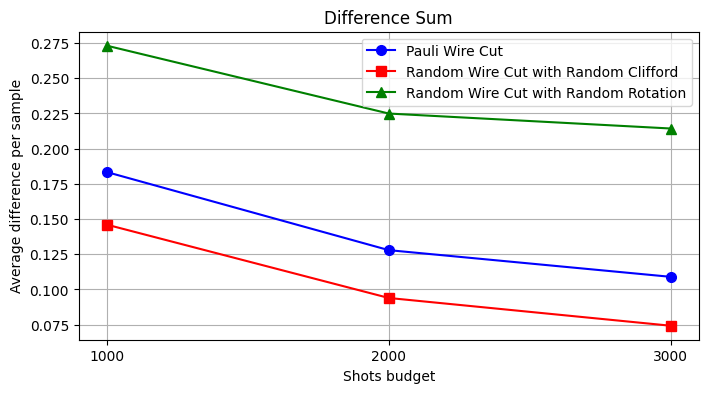

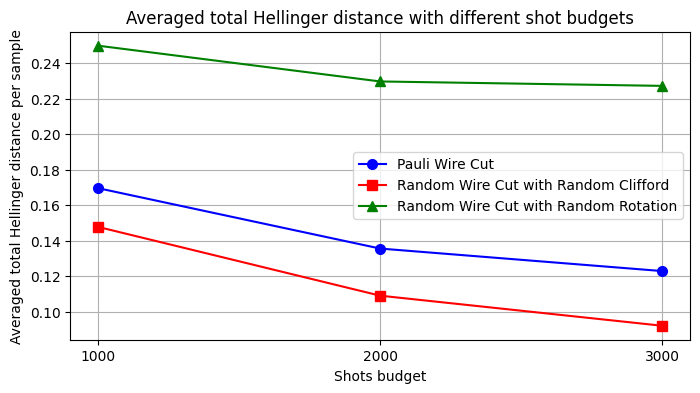

In [ ]:
# 8. Save the CSV file and binary file in the current directory.
benchmark = Benchmark.ImportFromBinary(OUTPUT_FILE_NAME)
shotsIntervals = [1000, 2000, 3000]

# 9. Create graphs based on the benchmark object.
dataLabels = ["Pauli Wire Cut", "Random Wire Cut with Random Clifford", "Random Wire Cut with Random Rotation"]
dataSets = []
dataSets.append(benchmark.GetWhere("Description", "Pauli wire cut", "Difference Sum"))
dataSets.append(benchmark.GetWhere("Description", "Random Clifford", "Difference Sum"))
dataSets.append(benchmark.GetWhere("Description", "Random rotation", "Difference Sum"))

qu.CustomPlot(dataLabels=dataLabels, xAxisLabels=shotsIntervals, dataSets=dataSets, title="Difference Sum", horizontalLabel="Shots budget", verticalLabel="Average difference per sample")
dataSets = []
dataSets.append(benchmark.GetWhere("Description", "Pauli wire cut", "Hellinger Distance"))
dataSets.append(benchmark.GetWhere("Description", "Random Clifford", "Hellinger Distance"))
dataSets.append(benchmark.GetWhere("Description", "Random rotation", "Hellinger Distance"))

qu.CustomPlot(dataLabels=dataLabels, xAxisLabels=shotsIntervals, dataSets=dataSets, title="Averaged total Hellinger distance with different shot budgets", horizontalLabel="Shots budget", verticalLabel="Averaged total Hellinger distance per sample")
